In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchvision

# It takes quite long time to train a GAN, better to save the snapshots/final model in your drive.
# Mount GoogleDrive here.
from google.colab import drive
drive.mount('/content/gdrive/')

# Check everything going well
# !ls /content/gdrive/'My Drive'

# Define some hyper parameters
epo_size  = 200
bch_size  = 100    # batch size
base_lr   = 0.0001 # learning rate
mnist_dim = 784    # =28x28, 28 is the height/width of a mnist image.
z_dim     = 100    # dimension of the random vector z for Generator's input.
save_root = F"/content/gdrive/MyDrive/"  # where to save your models.


# Define transform func.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

# Define dataloader
train_dataset = datasets.MNIST(root='./mnist_data/', train=True,  transform=transform, download=True )
test_dataset  = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)
train_loader  = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bch_size, shuffle=True )
test_loader   = torch.utils.data.DataLoader(dataset= test_dataset, batch_size=bch_size, shuffle=False)

Mounted at /content/gdrive/


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
# Define the two networks
class Generator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=784):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [ ]:
# Initialize a Generator and a Discriminator. 
G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).cuda()
D = Discriminator(mnist_dim).cuda()

In [ ]:
# Loss func. BCELoss means Binary Cross Entropy Loss.
criterion = nn.BCELoss() 

# Initialize the optimizer. Use Adam.
G_optimizer = optim.Adam(G.parameters(), lr = base_lr)
D_optimizer = optim.Adam(D.parameters(), lr = base_lr)

In [ ]:
# Code for training the discriminator.
def D_train(x, D_optimizer):
    D_optimizer.zero_grad()
    b,c,h,w = x.size()

    # train discriminator on real image
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(b, 1)
    x_real, y_real = Variable(x_real).cuda(), Variable(y_real).cuda()

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z      = Variable(torch.randn(b, z_dim)).cuda()
    y_fake = Variable(torch.zeros(b, 1)).cuda()
    x_fake = G(z)

    D_output = D(x_fake.detach()) # Detach the x_fake, no need grad. for Generator.
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # Only update D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [ ]:
# Code for training the generator
def G_train(bch_size, z_dim, G_optimizer):
    G_optimizer.zero_grad()

    z = Variable(torch.randn(bch_size, z_dim)).cuda()
    y = Variable(torch.ones(bch_size, 1)).cuda()

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y) # Fool the discriminator :P

    # Only update G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item(), G_output

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

def Logging(images, G_loss, D_loss):
    clear_output(wait=True)
    plt.clf()
    x_values = np.arange(0,len(G_loss), 1)
    fig, ax = plt.subplots()
    ax.plot(G_loss, label='G_loss')
    ax.plot(D_loss, label='D_loss')
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.grid(linestyle='-')
    plt.title("Training loss")
    plt.ylabel("Loss")
    plt.show()
    show_imgs = torchvision.utils.make_grid(G_output, nrow=10).numpy().transpose((1,2,0))
    plt.imshow(show_imgs)
    plt.show()
        
    

<Figure size 432x288 with 0 Axes>

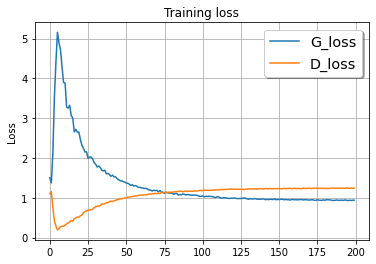

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


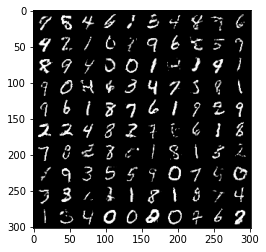

[200/200]: loss_d: 1.240, loss_g: 0.939
Training is finished.


In [ ]:
D_epoch_losses, G_epoch_losses = [], []   # record the average loss per epoch.
for epoch in range(1, epo_size+1):
    D_losses, G_losses = [], []     
    for iteration, (x, _) in enumerate(train_loader):
        # Train discriminator 
        D_loss = D_train(x, D_optimizer)
        D_losses.append(D_loss)
        # Train generator
        G_loss, G_output = G_train(bch_size, z_dim, G_optimizer)
        G_losses.append(G_loss)

    # Record losses for logging
    D_epoch_loss = torch.mean(torch.FloatTensor(D_losses))
    G_epoch_loss = torch.mean(torch.FloatTensor(G_losses))
    D_epoch_losses.append(D_epoch_loss)
    G_epoch_losses.append(G_epoch_loss)

    # Convert G_output to an image.
    G_output = G_output.detach().cpu()
    G_output = G_output.view(-1, 1, 28, 28)

    # Logging 
    Logging(G_output, G_epoch_losses, D_epoch_losses)
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), epo_size, D_epoch_loss, G_epoch_loss))
    
    # Save G/D models
    save_pth_G = save_root+'G_model.pt'
    save_pth_D = save_root+'D_model.pt'
    torch.save(G.state_dict(), save_pth_G)
    torch.save(D.state_dict(), save_pth_D)
print("Training is finished.")

In [ ]:
# Lets evaluate (have fun with) the Generative model!
import os

# Load the pretrained model for G
# - First check if the path is correct
os.path.isfile(save_pth_G)

# - Load pretrained G. 
G.load_state_dict(torch.load(save_pth_G))
G.eval()

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[ 1.3319, -1.7939,  0.6510, -0.0456,  0.9653,  0.4267,  0.6034,  0.3739,
          0.0371,  1.3116, -1.3073,  0.3166,  0.1823, -0.9793, -0.8949,  0.0887,
          0.6029,  1.6431,  0.9497, -0.0833, -0.6594, -0.2574,  0.6136,  0.4099,
          0.3209,  0.8264,  1.0338, -2.1359,  0.8622, -0.9737,  1.2565,  1.2629,
          0.8214, -0.0418, -0.5096,  1.6801, -0.8237,  0.0179,  0.6988, -0.2461,
          1.4188,  1.0375, -0.0650, -0.1608, -1.4040,  0.0918, -0.6466,  1.7992,
         -0.6746,  0.7195,  0.0028,  0.8255,  0.6061, -0.2376,  0.6338,  0.7979,
          0.8505,  0.8977, -1.8142, -1.6561,  0.0558, -0.3086, -0.6803, -0.2631,
          0.1198,  0.0874,  0.4023, -1.2749,  0.5639,  0.6952,  0.4274, -2.4245,
         -0.2063, -0.5090,  0.3182,  0.1857, -0.3777,  0.7154, -0.3786,  1.0571,
          1.8019, -0.8122, -0.3706,  0.7700,  0.1122, -0.0270, -0.5246, -1.2239,
          0.1856,  1.5425,  0.3172,  0.9636, -0.2757, -1.4367, -0.4300, -0.0153,
          0.5537, -1.3731, -

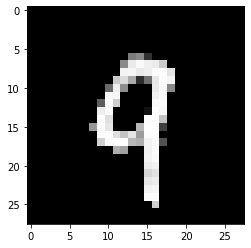

In [ ]:
# Run this block many times to generate random digit images.
# Have fun!

#z1 = Variable(torch.randn(1, z_dim)).cuda()

# see z, you should see a random vector
print(z1) 
#plt.hist(z1.cpu().numpy().flat, bins=20)
#plt.show()

# Generate img form z
img_vec = G(z1)
img = img_vec.view(1, 28, 28).data.cpu()
img = torchvision.utils.make_grid(img, nrow=1).numpy().transpose((1,2,0))
plt.imshow(img)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[-1.7870,  0.5879, -1.8414,  1.8812,  0.7957, -2.7532, -0.0780,  0.6262,
         -0.6961,  0.9540, -2.2150,  0.4719, -0.8507,  0.0186,  0.3428,  1.2143,
          0.5695, -0.1708, -0.6461, -0.3865,  0.4549, -2.9653,  0.2762,  0.2606,
          1.6394,  0.5637, -1.5359, -0.2431,  1.0673,  0.0387,  1.0756,  0.8218,
          1.5111,  0.6655,  2.3562, -0.9202,  0.3663,  0.4345,  0.3970, -0.8745,
          0.0466,  0.0744, -0.7687,  0.0378, -0.7770, -0.4122, -0.2270, -0.9892,
          0.6165,  0.1166,  0.5393, -0.6477, -1.4745, -0.5440, -0.0752, -2.1309,
         -0.5068, -0.9801,  1.0667,  0.5967,  1.0544,  0.8656,  1.1007, -2.7266,
         -0.4097, -0.7404, -1.0311,  1.3437,  0.4624, -0.6355, -0.7126, -0.1721,
         -1.0749, -0.0557,  0.2636,  0.6530,  0.2845,  1.5408, -2.1918, -0.7971,
         -0.2013, -0.2250, -0.9191, -1.7265, -1.2418, -0.3379,  0.2381, -0.6938,
         -0.6656,  0.1905, -0.5309, -1.5759,  0.9528,  0.2214,  0.5346, -2.1369,
         -0.2121,  0.3699, -

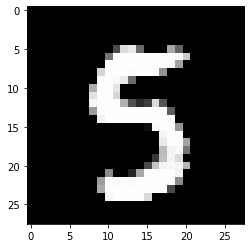

In [ ]:
# Run this block many times to generate random digit images.
# Have fun!

#z2 = Variable(torch.randn(1, z_dim)).cuda()

# see z, you should see a random vector
print(z2) 
#plt.hist(z2.cpu().numpy().flat, bins=20)
#plt.show()

# Generate img form z
img_vec = G(z2)
img = img_vec.view(1, 28, 28).data.cpu()
img = torchvision.utils.make_grid(img, nrow=1).numpy().transpose((1,2,0))
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

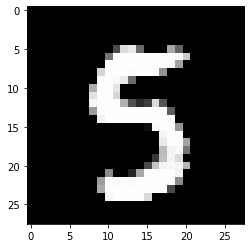

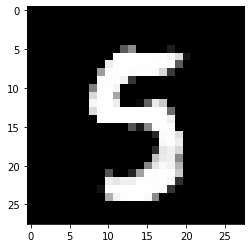

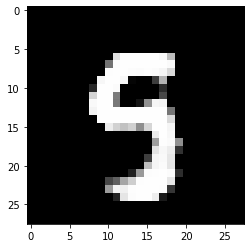

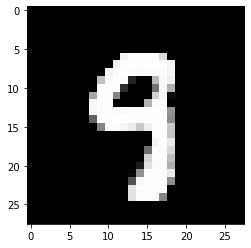

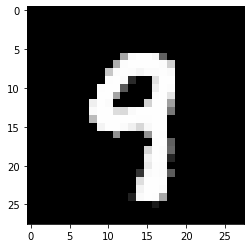

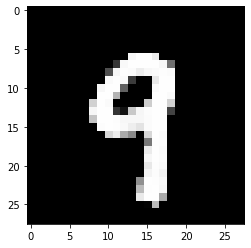

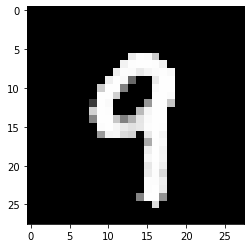

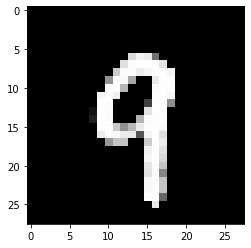

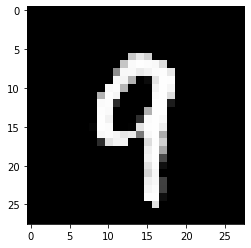

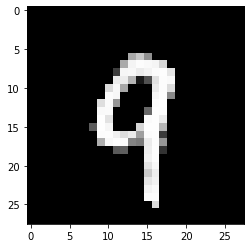

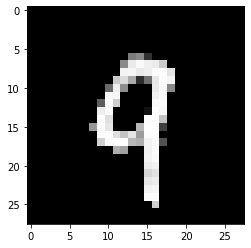

In [ ]:
# Run this block many times to generate random digit images.
# Have fun!

for ratio in range(11):
  z =  0.1 * (ratio * z1 + (10 - ratio) * z2)

  # see z, you should see a random vector
  #print(z2) 
  #plt.hist(z2.cpu().numpy().flat, bins=20)
  #plt.show()

  # Generate img form z
  img_vec = G(z)
  img = img_vec.view(1, 28, 28).data.cpu()
  img = torchvision.utils.make_grid(img, nrow=1).numpy().transpose((1,2,0))
  plt.figure()
  plt.imshow(img)